In [2]:
#files
import sys
#from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
#from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds
#from RNN_model import Simple_RNN
import utils_2 as ut2



#data and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

sns.set_style("darkgrid")


import numpy as np
import random
import os, errno
from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data_utils


np.random.seed(seed=77)
torch.manual_seed(77)

c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
fpath = "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/low/"
fname = "file7_080124.mat"
cutoff = [8/1000, 11/1000]

mat = ds.MatFileToDataFrame(fpath, fname)

df_ = mat.get_dataframe(cutoff)

x = dc.CaractDefect(df_)
taus = x.get_tau()[1]

hilbert, _ = x.get_hilbert()

df = pd.merge(df_, hilbert, on = 'Hilbert Transform', how = 'outer')

df.head()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.134180,0.023473,0.002203,0.002203-0.001490j,0.002659,-0.594742,-0.051439
1,0.135824,0.025117,0.002051,0.002051+0.000170j,0.002058,0.082612,-0.020024
2,0.136482,0.025775,0.001900,0.001900+0.000303j,0.001924,0.158163,0.009547
3,0.137797,0.027090,0.001749,0.001749+0.000903j,0.001969,0.476669,0.035605
4,0.137797,0.027090,0.001599,0.001599+0.000993j,0.001882,0.555726,0.056848


In [4]:
# Define the RNN model
class MultiStepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MultiStepRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        #out = self.fc(out)
        return out

In [9]:
# Function to prepare data with sliding window
def prepare_data(data, seq_length, output_size):
    sequences = []
    for i in range(len(data) - seq_length - output_size + 1):
        sequence = data[i:i+seq_length]
        target = data[i+seq_length:i+seq_length+output_size]
        sequences.append((sequence, target))
    return sequences

# Generate some sample data (replace this with your DataFrame column)
data_column = df['Amplitude'][300:50000].values  # Replace this with your actual data column

# Hyperparameters
input_size = 1
hidden_size = 64
output_size = 50
num_layers = 2
learning_rate = 0.001
num_epochs = 10
seq_length = 1000

# Prepare the data
data = prepare_data(data_column, seq_length, output_size)

# Split data into train, validation, and test sets
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

# Function to create batches
def create_batches(data, batch_size):
    batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        sequences, targets = zip(*batch)
        sequences = np.array(sequences)
        targets = np.array(targets)
        sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)
        targets = torch.tensor(targets, dtype=torch.float32)
        batches.append((sequences, targets))
    return batches

# Initialize the model, loss function, and optimizer
model = MultiStepRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


**Re hacer con las librerias y funciones ya hechas.**

In [15]:
train_loss, test_loss = ut2.simpleTrain_model(model,
                                              criterion,
                                              optimizer,
                                              x_train,
                                              x_val,
                                              y_train,
                                              y_
                                              num_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
# Training the model
train_losses = []
val_losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_batches = create_batches(train_data, batch_size=32)
    avg_loss = []
    for sequences, targets in train_batches:
        optimizer.zero_grad()
        outputs = model(sequences)
        #outputs = outputs[:,0,:]
        #print((outputs.size(), targets.size()))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        avg_loss.append(loss.item())
    train_losses.append(np.mean(avg_loss))

    # Validation loss
    model.eval()
    val_sequences, val_targets = zip(*val_data)
    val_sequences = torch.tensor(val_sequences, dtype=torch.float32).unsqueeze(-1)
    val_targets = torch.tensor(val_targets, dtype=torch.float32)
    with torch.no_grad():
        val_outputs = model(val_sequences)
        #val_outputs = val_outputs[:,0,:]
        val_loss = criterion(val_outputs, val_targets)
        val_losses.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')


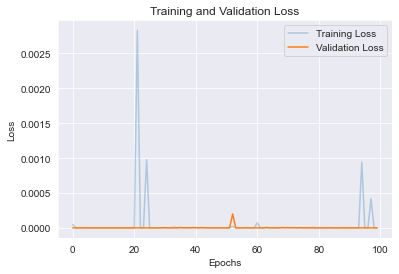

In [ ]:
# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss', alpha = 0.3)
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

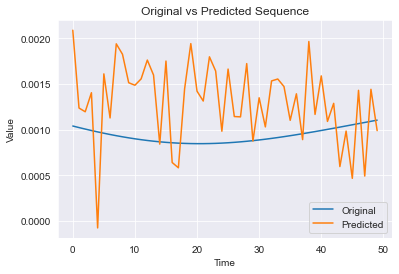

In [ ]:
#test model
model.eval()
test_sequences, test_targets = zip(*test_data)
test_sequences = torch.tensor(test_sequences, dtype=torch.float32).unsqueeze(-1)

def predict(model, data):
    model.eval()
    with torch.no_grad():
        #input_seq = torch.tensor(data, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        output_seq = model(data.unsqueeze(0))
        return output_seq.squeeze().numpy()

# Example usage:
predicted_sequence = predict(model, test_sequences[0])

def plot_sequence(original, predicted):
    plt.plot(original, label='Original')
    plt.plot(predicted, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Original vs Predicted Sequence')
    plt.legend()
    plt.show()

# Example usage:
plot_sequence(test_targets[0], predicted_sequence)